In [1]:
!pip3 install seaborn 

You should consider upgrading via the '/usr/local/opt/python/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import os
import time
import copy
import glob 
import torch
import random
import numpy as np
import matplotlib
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from PIL import Image as im
from model import Gauss2D

In [3]:
show        = True 
pretrain    = False
data_dir    = 'data'
filename    = 'model_out_gauss.pth'
batch_size  = 20       #Number of samples in each batch
num_workers = 4
epoch_num   = 5        #Number of epochs to train the network
lr          = 0.01     # Learning rate

In [4]:
data_transforms = {
    'train': transforms.ToTensor(),
    'val': transforms.ToTensor()
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=num_workers)
               for x in ['train', 'val']}
print(len(dataloaders['train']))
print(len(dataloaders['val']))

180
20


In [5]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device) 

cpu


In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Gauss2D.imshow(out,title=[class_names[x] for x in classes], fname='initial.jpg',show=False)


model_ft = models.resnet18(pretrained=pretrain)
if torch.cuda.device_count() > 1: 
    print("Using ", torch.cuda.device_count(),"gpus!")
    model_ft = nn.DataParallel(model_ft) #
    
model_ft=model_ft.to(device)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft = Gauss2D.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=epoch_num, dataloaders=dataloaders, device=device,dataset_sizes=dataset_sizes)
torch.save(model_ft, filename)

#Gauss2D.visualize_model(model_ft,num_images=4,device=device,dataloaders=dataloaders,class_names=class_names)

Epoch 0/4
----------
train Loss: 0.3209 Acc: 0.9200
val Loss: 0.1697 Acc: 0.9548

Epoch 1/4
----------
train Loss: 0.1420 Acc: 0.9506
val Loss: 0.0883 Acc: 0.9673

Epoch 2/4
----------
train Loss: 0.1364 Acc: 0.9528
val Loss: 0.1171 Acc: 0.9698

Epoch 3/4
----------
train Loss: 0.1170 Acc: 0.9586
val Loss: 0.0920 Acc: 0.9673

Epoch 4/4
----------
train Loss: 0.1059 Acc: 0.9672
val Loss: 0.0777 Acc: 0.9673

Training complete in 3m 40s
Best val Acc: 0.969849


[[192   7]
 [  5 194]]
[96.48241206 97.48743719]


Text(0.5, 1.0, 'Confusion Matrix')

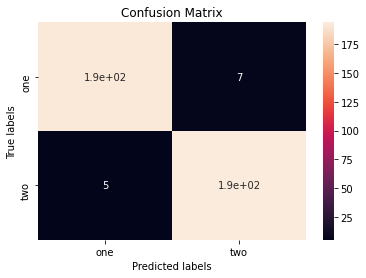

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
import pandas as pd 

nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)
labels = ['one','two']
ax= plt.subplot()


sns.heatmap(conf_mat, annot=True)
class_names = np.asarray(labels)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_xticklabels(class_names.flatten())
ax.set_yticklabels(class_names.flatten())
ax.set_title('Confusion Matrix')